# Unpickle the files from Inception v3 

# Unpickle the files from ResNet 50

Functionality of this part:
1. Read in the pickle filenames from the directory
2. For each pickle file:
    - Split the pickle filename into:
        - Source image
        - (x0,y0,x1,y1) values
        - Source class
        - Target class
    - Read in the image from the source image path
    - Load the pickle from the pickle filename and split it into R,G,B components
    - Add the scratch to the image using the (x,y) co-ordinates: this is now scratched_image
    
    For each machine learning model:
        find the prediction of scratched_image
    
    make a note of how many adversarial classes are the target class. This is our cross transferability measurement.
    
Viola!
We now have a cross transferability analysis.

In [190]:
# Import the required libraries
import pickle
from skimage.draw import line_aa
from skimage.draw import circle
from PIL import Image
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import pretrainedmodels
import pretrainedmodels.utils as utils
import requests

LABELS_URL = 'https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json'

labels = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

img_directory = '/home/malhar/Desktop/data/imagenet_validation_images/'

model_names = ['inceptionv3', 'resnet18', 'squeezenet1_0', 'squeezenet1_1', 'resnet50', 'vgg11_bn', 'vgg19', 'vgg16', 'resnet34', 'vgg13', 
           'densenet201', 'vgg13_bn', 'resnet152', 'vgg16_bn', 'resnet101', 
               'vgg19_bn', 'vgg11', 'alexnet']

load_img = utils.LoadImage()


data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

def prep_image_for_inference(img_path):
    input_img = load_img(img_path)
    input_tensor = tf_img(input_img)
    input_tensor = input_tensor.unsqueeze(0)
    input_to_model = torch.autograd.Variable(input_tensor,
            requires_grad=False)
#     input_to_model -= torch.min(input_to_model)
#     input_to_model = input_to_model / torch.max(input_to_model)
    return input_to_model


In [191]:
# Keep tally of correct and incorrect


# Get the required folder and the pickled files it
cwd = os.getcwd()
resnet50_dir = cwd + '/' + 'pickled_vgg19/'
resnet50_pickles = os.listdir(resnet50_dir)

# model_names = ['vgg19_bn', 'vgg16_bn', 'vgg13_bn', 'vgg11_bn']

for model_name in model_names:
    
    correct = 0
    incorrect = 0
    target_hits = 0
    original_hits = 0
    misclassified_hits = 0
    
    print (model_name)

    # Splice the filename and get the (x0, y0, x1, y1) values
    for pickled_filename in resnet50_pickles:
        # Splice filename into x0,y0,x1,y1 and original and target labels
        print (pickled_filename)
        list_of_split_filename = pickled_filename.split('_')
        source_image_path = list_of_split_filename[0] + '_' + list_of_split_filename[1] + '_' + list_of_split_filename[2]
        target_label = int(list_of_split_filename[3].split('target=')[1])
        original_label = int(list_of_split_filename[4].split('original=')[1])
        x0 = int(list_of_split_filename[6])
        y0 = int(list_of_split_filename[8])
        x1 = int(list_of_split_filename[10])
        y1 = int(list_of_split_filename[12].split('.p')[0])
#         print (x0, y0, x1, y1, original_label, target_label)
    #     print ('\n')

        # Read in each of the pickles
        pickleFile = open(resnet50_dir + pickled_filename, 'rb')
        adversarial_scratch = pickle.load(pickleFile)

        # Make the scratch
        rr, cc, val = line_aa(x0, y0, x1, y1)

        # Obtain the model
        model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
        model.eval()
        tf_img = utils.TransformImage(model)

        # Load the input to the model
        input_to_model = prep_image_for_inference(img_directory + source_image_path)

#         print (input_to_model.shape)
        if (input_to_model.shape[1] != 3):
            continue

        original_prediction = model(input_to_model)
    #         print ('Target: ', target_label, 'Original: ', original_label)
    #         print ('Prediction before adding the scratch: ', torch.argmax(original_prediction))

        # Add the scratch here to the image
        size= len(adversarial_scratch)
        r_vector = torch.from_numpy(adversarial_scratch[0:size/3])
        r_vector = r_vector.type(torch.float)

        g_vector = torch.from_numpy(adversarial_scratch[size/3: int(2*size/3)])
        g_vector = g_vector.type(torch.float)

        b_vector = torch.from_numpy(adversarial_scratch[int(2*size/3): size])
        b_vector = b_vector.type(torch.float)

        input_to_model[0,0,rr,cc] = r_vector
        input_to_model[0,1,rr,cc] = g_vector
        input_to_model[0,2,rr,cc] = b_vector

        adversarial_prediction = model(input_to_model)
    #         print ('Prediction after adding the scratch: ', torch.argmax(adversarial_prediction))
    #         print ('\n')

        if (torch.argmax(original_prediction) == original_label):
            correct += 1
        else:
            incorrect += 1

        if (torch.argmax(adversarial_prediction) == target_label):
            target_hits += 1

        elif (torch.argmax(adversarial_prediction) == original_label):
            original_hits += 1

        else:
            misclassified_hits += 1
    print (model_name, ', Target: ', target_hits, ', Original: ', original_hits, ', Misclassified: ', misclassified_hits)
    print ('\n')

inceptionv3
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_187_y0_144_x1_13_y1_109.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_144_y0_102_x1_205_y1_8.p
ILSVRC2012_val_00017877.JPEG_target=66_original=454_x0_129_y0_8_x1_54_y1_168.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_87_y0_107_x1_107_y1_21.p
ILSVRC2012_val_00014313.JPEG_target=167_original=800_x0_54_y0_167_x1_179_y1_13.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_148_y0_90_x1_107_y1_86.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_72_y0_1_x1_204_y1_144.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_61_y0_203_x1_116_y1_82.p
ILSVRC2012_val_00020189.JPEG_target=969_original=911_x0_56_y0_5_x1_219_y1_60.p
ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_217_y0_81_x1_110_y1_221.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_50_y0_130_x1_108_y1_83.p
ILSVRC2012_val_00025457.JPEG_target=655_original=821_x0_199_y0_44_x1_57_y1_189.p
ILSVRC2012_val_000311

ILSVRC2012_val_00014313.JPEG_target=167_original=800_x0_28_y0_10_x1_194_y1_220.p
ILSVRC2012_val_00042011.JPEG_target=604_original=928_x0_102_y0_83_x1_135_y1_143.p
ILSVRC2012_val_00038351.JPEG_target=797_original=773_x0_78_y0_23_x1_212_y1_175.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_112_y0_202_x1_30_y1_12.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_64_y0_80_x1_191_y1_32.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_6_y0_121_x1_191_y1_206.p
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_142_y0_63_x1_93_y1_198.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_167_y0_90_x1_183_y1_179.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_223_y0_70_x1_2_y1_4.p
ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_176_y0_121_x1_23_y1_5.p
ILSVRC2012_val_00043039.JPEG_target=551_original=929_x0_32_y0_49_x1_67_y1_211.p
ILSVRC2012_val_00022033.JPEG_target=112_original=843_x0_108_y0_150_x1_8_y1_26.p
ILSVRC2012_val_00007679.JPEG_target=

ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_214_y0_126_x1_129_y1_205.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_197_y0_192_x1_197_y1_69.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_27_y0_70_x1_215_y1_190.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_18_y0_165_x1_192_y1_142.p
ILSVRC2012_val_00026186.JPEG_target=803_original=258_x0_9_y0_59_x1_185_y1_116.p
ILSVRC2012_val_00043039.JPEG_target=551_original=929_x0_34_y0_1_x1_113_y1_95.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_147_y0_65_x1_69_y1_80.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_44_y0_160_x1_211_y1_185.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_105_y0_94_x1_211_y1_149.p
ILSVRC2012_val_00042482.JPEG_target=710_original=482_x0_196_y0_187_x1_100_y1_14.p
ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_81_y0_7_x1_42_y1_148.p
ILSVRC2012_val_00033601.JPEG_target=766_original=561_x0_192_y0_134_x1_66_y1_9.p
ILSVRC2012_val_00004395.JPEG_ta

ILSVRC2012_val_00020189.JPEG_target=969_original=911_x0_202_y0_3_x1_69_y1_192.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_37_y0_26_x1_149_y1_108.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_22_y0_124_x1_162_y1_135.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_215_y0_37_x1_151_y1_140.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_35_y0_55_x1_116_y1_158.p
ILSVRC2012_val_00033601.JPEG_target=766_original=561_x0_221_y0_220_x1_69_y1_75.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_129_y0_178_x1_60_y1_157.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_168_y0_42_x1_11_y1_120.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_87_y0_106_x1_216_y1_9.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_40_y0_110_x1_147_y1_70.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_220_y0_55_x1_69_y1_2.p
ILSVRC2012_val_00026186.JPEG_target=803_original=258_x0_196_y0_166_x1_17_y1_47.p
ILSVRC2012_val_00042786.JPEG_ta

/usr/local/lib/python2.7/dist-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/usr/local/lib/python2.7/dist-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)


ILSVRC2012_val_00017877.JPEG_target=66_original=454_x0_129_y0_8_x1_54_y1_168.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_87_y0_107_x1_107_y1_21.p
ILSVRC2012_val_00014313.JPEG_target=167_original=800_x0_54_y0_167_x1_179_y1_13.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_148_y0_90_x1_107_y1_86.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_72_y0_1_x1_204_y1_144.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_61_y0_203_x1_116_y1_82.p
ILSVRC2012_val_00020189.JPEG_target=969_original=911_x0_56_y0_5_x1_219_y1_60.p
ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_217_y0_81_x1_110_y1_221.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_50_y0_130_x1_108_y1_83.p
ILSVRC2012_val_00025457.JPEG_target=655_original=821_x0_199_y0_44_x1_57_y1_189.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_173_y0_178_x1_65_y1_204.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_11_y0_68_x1_108_y1_84.p
ILSVRC2012_val_00042861.JPEG_target

ILSVRC2012_val_00038351.JPEG_target=797_original=773_x0_78_y0_23_x1_212_y1_175.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_112_y0_202_x1_30_y1_12.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_64_y0_80_x1_191_y1_32.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_6_y0_121_x1_191_y1_206.p
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_142_y0_63_x1_93_y1_198.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_167_y0_90_x1_183_y1_179.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_223_y0_70_x1_2_y1_4.p
ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_176_y0_121_x1_23_y1_5.p
ILSVRC2012_val_00043039.JPEG_target=551_original=929_x0_32_y0_49_x1_67_y1_211.p
ILSVRC2012_val_00022033.JPEG_target=112_original=843_x0_108_y0_150_x1_8_y1_26.p
ILSVRC2012_val_00007679.JPEG_target=921_original=410_x0_110_y0_59_x1_51_y1_185.p
ILSVRC2012_val_00025457.JPEG_target=655_original=821_x0_32_y0_217_x1_179_y1_168.p
ILSVRC2012_val_00025774.JPEG_target=

ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_18_y0_165_x1_192_y1_142.p
ILSVRC2012_val_00026186.JPEG_target=803_original=258_x0_9_y0_59_x1_185_y1_116.p
ILSVRC2012_val_00043039.JPEG_target=551_original=929_x0_34_y0_1_x1_113_y1_95.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_147_y0_65_x1_69_y1_80.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_44_y0_160_x1_211_y1_185.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_105_y0_94_x1_211_y1_149.p
ILSVRC2012_val_00042482.JPEG_target=710_original=482_x0_196_y0_187_x1_100_y1_14.p
ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_81_y0_7_x1_42_y1_148.p
ILSVRC2012_val_00033601.JPEG_target=766_original=561_x0_192_y0_134_x1_66_y1_9.p
ILSVRC2012_val_00004395.JPEG_target=922_original=740_x0_173_y0_167_x1_39_y1_32.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_23_y0_53_x1_130_y1_46.p
ILSVRC2012_val_00033601.JPEG_target=766_original=561_x0_94_y0_158_x1_65_y1_22.p
ILSVRC2012_val_00035029.JPEG_target

ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_35_y0_55_x1_116_y1_158.p
ILSVRC2012_val_00033601.JPEG_target=766_original=561_x0_221_y0_220_x1_69_y1_75.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_129_y0_178_x1_60_y1_157.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_168_y0_42_x1_11_y1_120.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_87_y0_106_x1_216_y1_9.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_40_y0_110_x1_147_y1_70.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_220_y0_55_x1_69_y1_2.p
ILSVRC2012_val_00026186.JPEG_target=803_original=258_x0_196_y0_166_x1_17_y1_47.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_143_y0_19_x1_61_y1_146.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_125_y0_215_x1_93_y1_134.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_34_y0_65_x1_75_y1_181.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_54_y0_55_x1_221_y1_151.p
ILSVRC2012_val_00023541.JPEG_targe

ILSVRC2012_val_00025774.JPEG_target=201_original=540_x0_53_y0_16_x1_177_y1_207.p
ILSVRC2012_val_00024416.JPEG_target=211_original=626_x0_96_y0_9_x1_16_y1_221.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_122_y0_14_x1_66_y1_221.p
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_68_y0_190_x1_199_y1_45.p
ILSVRC2012_val_00023541.JPEG_target=520_original=179_x0_199_y0_153_x1_66_y1_215.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_153_y0_112_x1_168_y1_170.p
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_24_y0_38_x1_169_y1_18.p
ILSVRC2012_val_00022033.JPEG_target=112_original=843_x0_7_y0_122_x1_222_y1_129.p
ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_129_y0_121_x1_196_y1_195.p
ILSVRC2012_val_00023541.JPEG_target=520_original=179_x0_52_y0_105_x1_189_y1_63.p
ILSVRC2012_val_00037423.JPEG_target=172_original=848_x0_30_y0_210_x1_217_y1_192.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_92_y0_100_x1_209_y1_130.p
ILSVRC2012_val_00042000.JPE

ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_50_y0_83_x1_223_y1_120.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_161_y0_164_x1_75_y1_6.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_135_y0_96_x1_6_y1_141.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_199_y0_133_x1_49_y1_27.p
ILSVRC2012_val_00022033.JPEG_target=112_original=843_x0_182_y0_73_x1_73_y1_187.p
ILSVRC2012_val_00033166.JPEG_target=86_original=834_x0_100_y0_131_x1_194_y1_158.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_205_y0_213_x1_52_y1_75.p
ILSVRC2012_val_00023204.JPEG_target=646_original=69_x0_208_y0_121_x1_67_y1_75.p
ILSVRC2012_val_00026186.JPEG_target=803_original=258_x0_221_y0_11_x1_37_y1_154.p
ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_131_y0_203_x1_100_y1_74.p
ILSVRC2012_val_00003239.JPEG_target=819_original=320_x0_191_y0_27_x1_7_y1_175.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_113_y0_124_x1_178_y1_185.p
ILSVRC2012_val_00033601.JPEG

ILSVRC2012_val_00042482.JPEG_target=710_original=482_x0_92_y0_199_x1_220_y1_137.p
ILSVRC2012_val_00043039.JPEG_target=551_original=929_x0_21_y0_17_x1_206_y1_193.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_93_y0_176_x1_116_y1_48.p
ILSVRC2012_val_00026394.JPEG_target=591_original=447_x0_159_y0_35_x1_153_y1_207.p
ILSVRC2012_val_00007679.JPEG_target=921_original=410_x0_215_y0_113_x1_93_y1_60.p
ILSVRC2012_val_00040397.JPEG_target=280_original=308_x0_106_y0_44_x1_39_y1_203.p
ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_60_y0_86_x1_119_y1_200.p
ILSVRC2012_val_00025774.JPEG_target=201_original=540_x0_218_y0_100_x1_65_y1_179.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_81_y0_66_x1_26_y1_213.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_73_y0_137_x1_34_y1_41.p
ILSVRC2012_val_00023383.JPEG_target=344_original=335_x0_108_y0_13_x1_67_y1_151.p
ILSVRC2012_val_00033601.JPEG_target=766_original=561_x0_163_y0_112_x1_67_y1_210.p
ILSVRC2012_val_00034885.JP

ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_119_y0_113_x1_156_y1_215.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_148_y0_68_x1_64_y1_2.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_166_y0_97_x1_92_y1_59.p
ILSVRC2012_val_00042011.JPEG_target=604_original=928_x0_82_y0_186_x1_65_y1_15.p
ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_121_y0_56_x1_211_y1_11.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_132_y0_8_x1_199_y1_134.p
ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_156_y0_151_x1_163_y1_2.p
ILSVRC2012_val_00015157.JPEG_target=45_original=2_x0_109_y0_184_x1_4_y1_37.p
ILSVRC2012_val_00016554.JPEG_target=774_original=120_x0_178_y0_201_x1_158_y1_36.p
ILSVRC2012_val_00025457.JPEG_target=655_original=821_x0_73_y0_216_x1_216_y1_139.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_147_y0_87_x1_77_y1_221.p
ILSVRC2012_val_00042482.JPEG_target=710_original=482_x0_60_y0_139_x1_148_y1_222.p
ILSVRC2012_val_00004294.JPEG_targ

ILSVRC2012_val_00042011.JPEG_target=604_original=928_x0_87_y0_198_x1_177_y1_1.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_54_y0_60_x1_106_y1_200.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_155_y0_171_x1_86_y1_117.p
ILSVRC2012_val_00023541.JPEG_target=520_original=179_x0_59_y0_56_x1_138_y1_220.p
ILSVRC2012_val_00037423.JPEG_target=172_original=848_x0_27_y0_37_x1_189_y1_120.p
ILSVRC2012_val_00007679.JPEG_target=921_original=410_x0_41_y0_175_x1_135_y1_59.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_188_y0_175_x1_26_y1_16.p
ILSVRC2012_val_00026394.JPEG_target=591_original=447_x0_179_y0_58_x1_72_y1_9.p
ILSVRC2012_val_00020189.JPEG_target=969_original=911_x0_122_y0_5_x1_90_y1_205.p
ILSVRC2012_val_00014313.JPEG_target=167_original=800_x0_13_y0_206_x1_212_y1_82.p
ILSVRC2012_val_00023415.JPEG_target=592_original=273_x0_60_y0_14_x1_192_y1_160.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_60_y0_80_x1_219_y1_95.p
ILSVRC2012_val_00004963.JPEG_target

ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_83_y0_212_x1_182_y1_74.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_193_y0_75_x1_107_y1_117.p
ILSVRC2012_val_00025978.JPEG_target=497_original=770_x0_79_y0_29_x1_207_y1_38.p
ILSVRC2012_val_00025978.JPEG_target=497_original=770_x0_132_y0_193_x1_30_y1_159.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_212_y0_79_x1_93_y1_71.p
ILSVRC2012_val_00033166.JPEG_target=86_original=834_x0_2_y0_132_x1_131_y1_217.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_176_y0_155_x1_36_y1_54.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_33_y0_196_x1_37_y1_38.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_22_y0_0_x1_219_y1_83.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_22_y0_134_x1_205_y1_161.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_1_y0_130_x1_213_y1_74.p
ILSVRC2012_val_00040397.JPEG_target=280_original=308_x0_48_y0_157_x1_175_y1_146.p
ILSVRC2012_val_00042000.JPEG_targ

ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_133_y0_95_x1_62_y1_139.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_4_y0_218_x1_206_y1_23.p
ILSVRC2012_val_00007679.JPEG_target=921_original=410_x0_222_y0_23_x1_54_y1_83.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_222_y0_27_x1_10_y1_82.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_137_y0_57_x1_103_y1_98.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_161_y0_189_x1_41_y1_127.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_160_y0_95_x1_68_y1_76.p
ILSVRC2012_val_00029710.JPEG_target=2_original=145_x0_62_y0_116_x1_206_y1_26.p
ILSVRC2012_val_00042011.JPEG_target=604_original=928_x0_35_y0_222_x1_215_y1_17.p
ILSVRC2012_val_00042011.JPEG_target=604_original=928_x0_84_y0_196_x1_178_y1_146.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_98_y0_131_x1_66_y1_199.p
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_181_y0_214_x1_173_y1_32.p
ILSVRC2012_val_00023204.JPEG_tar

ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_178_y0_32_x1_7_y1_127.p
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_213_y0_164_x1_75_y1_129.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_187_y0_34_x1_76_y1_67.p
ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_166_y0_155_x1_18_y1_139.p
ILSVRC2012_val_00038351.JPEG_target=797_original=773_x0_87_y0_100_x1_196_y1_162.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_111_y0_140_x1_209_y1_212.p
ILSVRC2012_val_00025978.JPEG_target=497_original=770_x0_143_y0_207_x1_68_y1_103.p
('vgg16', ', Target: ', 0, ', Original: ', 88, ', Misclassified: ', 100)


resnet34
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_187_y0_144_x1_13_y1_109.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_144_y0_102_x1_205_y1_8.p
ILSVRC2012_val_00017877.JPEG_target=66_original=454_x0_129_y0_8_x1_54_y1_168.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_87_y0_107_x1_107_y1_21.p
ILSVRC2012_val_00014313

ILSVRC2012_val_00020692.JPEG_target=269_original=78_x0_0_y0_153_x1_211_y1_121.p
ILSVRC2012_val_00019509.JPEG_target=778_original=609_x0_40_y0_93_x1_137_y1_206.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_136_y0_82_x1_164_y1_159.p
ILSVRC2012_val_00017877.JPEG_target=66_original=454_x0_100_y0_219_x1_158_y1_114.p
ILSVRC2012_val_00043039.JPEG_target=551_original=929_x0_23_y0_9_x1_121_y1_129.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_21_y0_78_x1_99_y1_95.p
ILSVRC2012_val_00007679.JPEG_target=921_original=410_x0_200_y0_2_x1_129_y1_159.p
ILSVRC2012_val_00014313.JPEG_target=167_original=800_x0_148_y0_169_x1_15_y1_9.p
ILSVRC2012_val_00014313.JPEG_target=167_original=800_x0_28_y0_10_x1_194_y1_220.p
ILSVRC2012_val_00042011.JPEG_target=604_original=928_x0_102_y0_83_x1_135_y1_143.p
ILSVRC2012_val_00038351.JPEG_target=797_original=773_x0_78_y0_23_x1_212_y1_175.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_112_y0_202_x1_30_y1_12.p
ILSVRC2012_val_00008266.JPEG_t

ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_61_y0_203_x1_116_y1_82.p
ILSVRC2012_val_00020189.JPEG_target=969_original=911_x0_56_y0_5_x1_219_y1_60.p
ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_217_y0_81_x1_110_y1_221.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_50_y0_130_x1_108_y1_83.p
ILSVRC2012_val_00025457.JPEG_target=655_original=821_x0_199_y0_44_x1_57_y1_189.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_173_y0_178_x1_65_y1_204.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_11_y0_68_x1_108_y1_84.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_199_y0_189_x1_2_y1_99.p
ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_214_y0_126_x1_129_y1_205.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_197_y0_192_x1_197_y1_69.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_27_y0_70_x1_215_y1_190.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_18_y0_165_x1_192_y1_142.p
ILSVRC2012_val_00026186.JPEG_ta

ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_167_y0_90_x1_183_y1_179.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_223_y0_70_x1_2_y1_4.p
ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_176_y0_121_x1_23_y1_5.p
ILSVRC2012_val_00043039.JPEG_target=551_original=929_x0_32_y0_49_x1_67_y1_211.p
ILSVRC2012_val_00022033.JPEG_target=112_original=843_x0_108_y0_150_x1_8_y1_26.p
ILSVRC2012_val_00007679.JPEG_target=921_original=410_x0_110_y0_59_x1_51_y1_185.p
ILSVRC2012_val_00025457.JPEG_target=655_original=821_x0_32_y0_217_x1_179_y1_168.p
ILSVRC2012_val_00025774.JPEG_target=201_original=540_x0_10_y0_115_x1_196_y1_155.p
ILSVRC2012_val_00020189.JPEG_target=969_original=911_x0_202_y0_3_x1_69_y1_192.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_37_y0_26_x1_149_y1_108.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_22_y0_124_x1_162_y1_135.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_215_y0_37_x1_151_y1_140.p
ILSVRC2012_val_00035029.JPEG_targe

/usr/local/lib/python2.7/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_144_y0_102_x1_205_y1_8.p
ILSVRC2012_val_00017877.JPEG_target=66_original=454_x0_129_y0_8_x1_54_y1_168.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_87_y0_107_x1_107_y1_21.p
ILSVRC2012_val_00014313.JPEG_target=167_original=800_x0_54_y0_167_x1_179_y1_13.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_148_y0_90_x1_107_y1_86.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_72_y0_1_x1_204_y1_144.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_61_y0_203_x1_116_y1_82.p
ILSVRC2012_val_00020189.JPEG_target=969_original=911_x0_56_y0_5_x1_219_y1_60.p
ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_217_y0_81_x1_110_y1_221.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_50_y0_130_x1_108_y1_83.p
ILSVRC2012_val_00025457.JPEG_target=655_original=821_x0_199_y0_44_x1_57_y1_189.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_173_y0_178_x1_65_y1_204.p
ILSVRC2012_val_00035029.JPEG_target

ILSVRC2012_val_00042011.JPEG_target=604_original=928_x0_102_y0_83_x1_135_y1_143.p
ILSVRC2012_val_00038351.JPEG_target=797_original=773_x0_78_y0_23_x1_212_y1_175.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_112_y0_202_x1_30_y1_12.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_64_y0_80_x1_191_y1_32.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_6_y0_121_x1_191_y1_206.p
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_142_y0_63_x1_93_y1_198.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_167_y0_90_x1_183_y1_179.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_223_y0_70_x1_2_y1_4.p
ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_176_y0_121_x1_23_y1_5.p
ILSVRC2012_val_00043039.JPEG_target=551_original=929_x0_32_y0_49_x1_67_y1_211.p
ILSVRC2012_val_00022033.JPEG_target=112_original=843_x0_108_y0_150_x1_8_y1_26.p
ILSVRC2012_val_00007679.JPEG_target=921_original=410_x0_110_y0_59_x1_51_y1_185.p
ILSVRC2012_val_00025457.JPEG_target=

ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_197_y0_192_x1_197_y1_69.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_27_y0_70_x1_215_y1_190.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_18_y0_165_x1_192_y1_142.p
ILSVRC2012_val_00026186.JPEG_target=803_original=258_x0_9_y0_59_x1_185_y1_116.p
ILSVRC2012_val_00043039.JPEG_target=551_original=929_x0_34_y0_1_x1_113_y1_95.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_147_y0_65_x1_69_y1_80.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_44_y0_160_x1_211_y1_185.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_105_y0_94_x1_211_y1_149.p
ILSVRC2012_val_00042482.JPEG_target=710_original=482_x0_196_y0_187_x1_100_y1_14.p
ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_81_y0_7_x1_42_y1_148.p
ILSVRC2012_val_00033601.JPEG_target=766_original=561_x0_192_y0_134_x1_66_y1_9.p
ILSVRC2012_val_00004395.JPEG_target=922_original=740_x0_173_y0_167_x1_39_y1_32.p
ILSVRC2012_val_00035029.JPEG_targ

ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_37_y0_26_x1_149_y1_108.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_22_y0_124_x1_162_y1_135.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_215_y0_37_x1_151_y1_140.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_35_y0_55_x1_116_y1_158.p
ILSVRC2012_val_00033601.JPEG_target=766_original=561_x0_221_y0_220_x1_69_y1_75.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_129_y0_178_x1_60_y1_157.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_168_y0_42_x1_11_y1_120.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_87_y0_106_x1_216_y1_9.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_40_y0_110_x1_147_y1_70.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_220_y0_55_x1_69_y1_2.p
ILSVRC2012_val_00026186.JPEG_target=803_original=258_x0_196_y0_166_x1_17_y1_47.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_143_y0_19_x1_61_y1_146.p
ILSVRC2012_val_00031138.JPEG_ta

ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_2_y0_189_x1_136_y1_178.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_208_y0_191_x1_108_y1_47.p
ILSVRC2012_val_00042482.JPEG_target=710_original=482_x0_188_y0_106_x1_38_y1_43.p
ILSVRC2012_val_00025774.JPEG_target=201_original=540_x0_53_y0_16_x1_177_y1_207.p
ILSVRC2012_val_00024416.JPEG_target=211_original=626_x0_96_y0_9_x1_16_y1_221.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_122_y0_14_x1_66_y1_221.p
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_68_y0_190_x1_199_y1_45.p
ILSVRC2012_val_00023541.JPEG_target=520_original=179_x0_199_y0_153_x1_66_y1_215.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_153_y0_112_x1_168_y1_170.p
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_24_y0_38_x1_169_y1_18.p
ILSVRC2012_val_00022033.JPEG_target=112_original=843_x0_7_y0_122_x1_222_y1_129.p
ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_129_y0_121_x1_196_y1_195.p
ILSVRC2012_val_00023541.JPEG

ILSVRC2012_val_00023541.JPEG_target=520_original=179_x0_55_y0_97_x1_187_y1_31.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_219_y0_18_x1_30_y1_121.p
ILSVRC2012_val_00024416.JPEG_target=211_original=626_x0_73_y0_167_x1_220_y1_92.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_50_y0_83_x1_223_y1_120.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_161_y0_164_x1_75_y1_6.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_135_y0_96_x1_6_y1_141.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_199_y0_133_x1_49_y1_27.p
ILSVRC2012_val_00022033.JPEG_target=112_original=843_x0_182_y0_73_x1_73_y1_187.p
ILSVRC2012_val_00033166.JPEG_target=86_original=834_x0_100_y0_131_x1_194_y1_158.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_205_y0_213_x1_52_y1_75.p
ILSVRC2012_val_00023204.JPEG_target=646_original=69_x0_208_y0_121_x1_67_y1_75.p
ILSVRC2012_val_00026186.JPEG_target=803_original=258_x0_221_y0_11_x1_37_y1_154.p
ILSVRC2012_val_00031587.JPEG_ta

ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_136_y0_101_x1_78_y1_218.p
ILSVRC2012_val_00025457.JPEG_target=655_original=821_x0_209_y0_97_x1_28_y1_131.p
ILSVRC2012_val_00025978.JPEG_target=497_original=770_x0_199_y0_179_x1_126_y1_177.p
ILSVRC2012_val_00042482.JPEG_target=710_original=482_x0_92_y0_199_x1_220_y1_137.p
ILSVRC2012_val_00043039.JPEG_target=551_original=929_x0_21_y0_17_x1_206_y1_193.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_93_y0_176_x1_116_y1_48.p
ILSVRC2012_val_00026394.JPEG_target=591_original=447_x0_159_y0_35_x1_153_y1_207.p
ILSVRC2012_val_00007679.JPEG_target=921_original=410_x0_215_y0_113_x1_93_y1_60.p
ILSVRC2012_val_00040397.JPEG_target=280_original=308_x0_106_y0_44_x1_39_y1_203.p
ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_60_y0_86_x1_119_y1_200.p
ILSVRC2012_val_00025774.JPEG_target=201_original=540_x0_218_y0_100_x1_65_y1_179.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_81_y0_66_x1_26_y1_213.p
ILSVRC2012_val_00008266

ILSVRC2012_val_00033601.JPEG_target=766_original=561_x0_83_y0_213_x1_58_y1_20.p
ILSVRC2012_val_00026186.JPEG_target=803_original=258_x0_149_y0_113_x1_52_y1_105.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_109_y0_201_x1_49_y1_85.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_119_y0_113_x1_156_y1_215.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_148_y0_68_x1_64_y1_2.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_166_y0_97_x1_92_y1_59.p
ILSVRC2012_val_00042011.JPEG_target=604_original=928_x0_82_y0_186_x1_65_y1_15.p
ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_121_y0_56_x1_211_y1_11.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_132_y0_8_x1_199_y1_134.p
ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_156_y0_151_x1_163_y1_2.p
ILSVRC2012_val_00015157.JPEG_target=45_original=2_x0_109_y0_184_x1_4_y1_37.p
ILSVRC2012_val_00016554.JPEG_target=774_original=120_x0_178_y0_201_x1_158_y1_36.p
ILSVRC2012_val_00025457.JPEG_targe

ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_186_y0_132_x1_113_y1_152.p
ILSVRC2012_val_00042011.JPEG_target=604_original=928_x0_178_y0_13_x1_141_y1_131.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_112_y0_26_x1_33_y1_205.p
ILSVRC2012_val_00042011.JPEG_target=604_original=928_x0_87_y0_198_x1_177_y1_1.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_54_y0_60_x1_106_y1_200.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_155_y0_171_x1_86_y1_117.p
ILSVRC2012_val_00023541.JPEG_target=520_original=179_x0_59_y0_56_x1_138_y1_220.p
ILSVRC2012_val_00037423.JPEG_target=172_original=848_x0_27_y0_37_x1_189_y1_120.p
ILSVRC2012_val_00007679.JPEG_target=921_original=410_x0_41_y0_175_x1_135_y1_59.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_188_y0_175_x1_26_y1_16.p
ILSVRC2012_val_00026394.JPEG_target=591_original=447_x0_179_y0_58_x1_72_y1_9.p
ILSVRC2012_val_00020189.JPEG_target=969_original=911_x0_122_y0_5_x1_90_y1_205.p
ILSVRC2012_val_00014313.JPEG_ta

ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_171_y0_149_x1_95_y1_78.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_112_y0_44_x1_53_y1_182.p
ILSVRC2012_val_00040397.JPEG_target=280_original=308_x0_164_y0_136_x1_27_y1_120.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_83_y0_212_x1_182_y1_74.p
ILSVRC2012_val_00004294.JPEG_target=483_original=375_x0_193_y0_75_x1_107_y1_117.p
ILSVRC2012_val_00025978.JPEG_target=497_original=770_x0_79_y0_29_x1_207_y1_38.p
ILSVRC2012_val_00025978.JPEG_target=497_original=770_x0_132_y0_193_x1_30_y1_159.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_212_y0_79_x1_93_y1_71.p
ILSVRC2012_val_00033166.JPEG_target=86_original=834_x0_2_y0_132_x1_131_y1_217.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_176_y0_155_x1_36_y1_54.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_33_y0_196_x1_37_y1_38.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_22_y0_0_x1_219_y1_83.p
ILSVRC2012_val_00036553.JPEG_target

ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_78_y0_141_x1_98_y1_30.p
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_193_y0_155_x1_16_y1_4.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_113_y0_203_x1_29_y1_34.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_133_y0_95_x1_62_y1_139.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_4_y0_218_x1_206_y1_23.p
ILSVRC2012_val_00007679.JPEG_target=921_original=410_x0_222_y0_23_x1_54_y1_83.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_222_y0_27_x1_10_y1_82.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_137_y0_57_x1_103_y1_98.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_161_y0_189_x1_41_y1_127.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_160_y0_95_x1_68_y1_76.p
ILSVRC2012_val_00029710.JPEG_target=2_original=145_x0_62_y0_116_x1_206_y1_26.p
ILSVRC2012_val_00042011.JPEG_target=604_original=928_x0_35_y0_222_x1_215_y1_17.p
ILSVRC2012_val_00042011.JPEG_target=6

ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_178_y0_129_x1_27_y1_214.p
ILSVRC2012_val_00014313.JPEG_target=167_original=800_x0_110_y0_127_x1_62_y1_24.p
ILSVRC2012_val_00020692.JPEG_target=269_original=78_x0_7_y0_71_x1_44_y1_216.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_178_y0_32_x1_7_y1_127.p
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_213_y0_164_x1_75_y1_129.p
ILSVRC2012_val_00036553.JPEG_target=914_original=646_x0_187_y0_34_x1_76_y1_67.p
ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_166_y0_155_x1_18_y1_139.p
ILSVRC2012_val_00038351.JPEG_target=797_original=773_x0_87_y0_100_x1_196_y1_162.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_111_y0_140_x1_209_y1_212.p
ILSVRC2012_val_00025978.JPEG_target=497_original=770_x0_143_y0_207_x1_68_y1_103.p
('vgg19_bn', ', Target: ', 188, ', Original: ', 0, ', Misclassified: ', 0)


vgg11
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_187_y0_144_x1_13_y1_109.p
ILSVRC2012_val_00023118

ILSVRC2012_val_00023204.JPEG_target=646_original=69_x0_212_y0_98_x1_147_y1_35.p
ILSVRC2012_val_00025978.JPEG_target=497_original=770_x0_81_y0_91_x1_199_y1_216.p
ILSVRC2012_val_00023204.JPEG_target=646_original=69_x0_48_y0_80_x1_172_y1_100.p
ILSVRC2012_val_00020692.JPEG_target=269_original=78_x0_0_y0_153_x1_211_y1_121.p
ILSVRC2012_val_00019509.JPEG_target=778_original=609_x0_40_y0_93_x1_137_y1_206.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_136_y0_82_x1_164_y1_159.p
ILSVRC2012_val_00017877.JPEG_target=66_original=454_x0_100_y0_219_x1_158_y1_114.p
ILSVRC2012_val_00043039.JPEG_target=551_original=929_x0_23_y0_9_x1_121_y1_129.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_21_y0_78_x1_99_y1_95.p
ILSVRC2012_val_00007679.JPEG_target=921_original=410_x0_200_y0_2_x1_129_y1_159.p
ILSVRC2012_val_00014313.JPEG_target=167_original=800_x0_148_y0_169_x1_15_y1_9.p
ILSVRC2012_val_00014313.JPEG_target=167_original=800_x0_28_y0_10_x1_194_y1_220.p
ILSVRC2012_val_00042011.JPEG_targ

ILSVRC2012_val_00014313.JPEG_target=167_original=800_x0_54_y0_167_x1_179_y1_13.p
ILSVRC2012_val_00034885.JPEG_target=451_original=871_x0_148_y0_90_x1_107_y1_86.p
ILSVRC2012_val_00023118.JPEG_target=731_original=89_x0_72_y0_1_x1_204_y1_144.p
ILSVRC2012_val_00012812.JPEG_target=764_original=449_x0_61_y0_203_x1_116_y1_82.p
ILSVRC2012_val_00020189.JPEG_target=969_original=911_x0_56_y0_5_x1_219_y1_60.p
ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_217_y0_81_x1_110_y1_221.p
ILSVRC2012_val_00036478.JPEG_target=681_original=195_x0_50_y0_130_x1_108_y1_83.p
ILSVRC2012_val_00025457.JPEG_target=655_original=821_x0_199_y0_44_x1_57_y1_189.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_173_y0_178_x1_65_y1_204.p
ILSVRC2012_val_00035029.JPEG_target=141_original=337_x0_11_y0_68_x1_108_y1_84.p
ILSVRC2012_val_00042861.JPEG_target=338_original=606_x0_199_y0_189_x1_2_y1_99.p
ILSVRC2012_val_00031587.JPEG_target=947_original=356_x0_214_y0_126_x1_129_y1_205.p
ILSVRC2012_val_00023118.JPEG_tar

ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_64_y0_80_x1_191_y1_32.p
ILSVRC2012_val_00008266.JPEG_target=679_original=944_x0_6_y0_121_x1_191_y1_206.p
ILSVRC2012_val_00004963.JPEG_target=378_original=243_x0_142_y0_63_x1_93_y1_198.p
ILSVRC2012_val_00031138.JPEG_target=115_original=1_x0_167_y0_90_x1_183_y1_179.p
ILSVRC2012_val_00042786.JPEG_target=141_original=72_x0_223_y0_70_x1_2_y1_4.p
ILSVRC2012_val_00042000.JPEG_target=445_original=130_x0_176_y0_121_x1_23_y1_5.p
ILSVRC2012_val_00043039.JPEG_target=551_original=929_x0_32_y0_49_x1_67_y1_211.p
ILSVRC2012_val_00022033.JPEG_target=112_original=843_x0_108_y0_150_x1_8_y1_26.p
ILSVRC2012_val_00007679.JPEG_target=921_original=410_x0_110_y0_59_x1_51_y1_185.p
ILSVRC2012_val_00025457.JPEG_target=655_original=821_x0_32_y0_217_x1_179_y1_168.p
ILSVRC2012_val_00025774.JPEG_target=201_original=540_x0_10_y0_115_x1_196_y1_155.p
ILSVRC2012_val_00020189.JPEG_target=969_original=911_x0_202_y0_3_x1_69_y1_192.p
ILSVRC2012_val_00023118.JPEG_target=

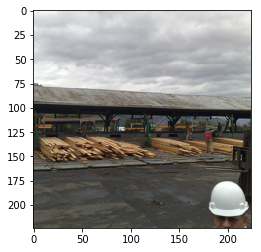

In [161]:
plt.imshow(  input_to_model.detach()[0,:,:,:].permute(1, 2, 0)  )

In [178]:
correct,incorrect,target_hits

(196, 64, 0)

257